# EEG Statistics

### Group analysis
In this notebook we are going to introduce group analysis for EEG using the data from your FaceWord experiment.

## Evokeds
Ideally, we would use evokeds/ERPs from all participants but for now, we'll just look at evokeds from two participants. We'll be looking at the words/images contrast.

(Tip: You can run terminal commands from cells using the os.system() function or simply writing an exclamation mark before the command)

In [2]:
# importing modules
import os
import pip
!python -m pip install mne
!python -m pip install pandas
os.system('python -m pip install scikit-learn')
import numpy as np
import pandas as pd
import mne

In [ ]:
# reading in the evokeds from the two conditions for both participants
word_evoked1 = mne.read_evokeds('faceword1word-ave.fif', condition = 0)
image_evoked1 = mne.read_evokeds('faceword1image-ave.fif', condition = 0)

# removing channels
word_evoked1.drop_channels('FC2')
image_evoked1.drop_channels('FC2')

word_evoked2 = mne.read_evokeds('faceword2word-ave.fif', condition = 0)
image_evoked2 = mne.read_evokeds('faceword2image-ave.fif', condition = 0)

In [7]:
# creating a list of evokeds for each condition
word_evokeds = word_evoked1, word_evoked2
image_evokeds = image_evoked1, image_evoked2

Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.


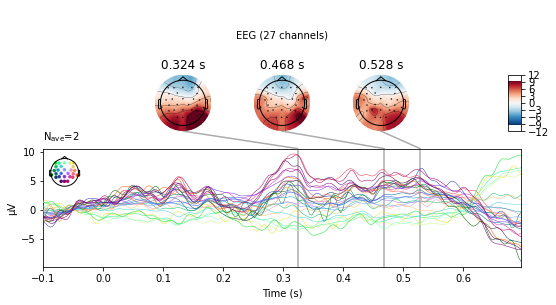

Identifying common channels ...
No projector specified for this dataset. Please consider the method self.add_proj.


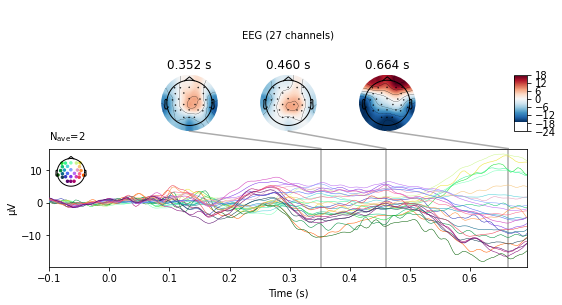

In [8]:
word_avg = mne.grand_average(word_evokeds)
word_avg.plot_joint();

image_avg = mne.grand_average(image_evokeds)
image_avg.plot_joint();

## Windowed mean
Now we have our two conditions: trials with words vs images. One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1) Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature. 
2) Taking the mean of that window across channels, samples and trials.
3) Running statistical tests on the windowed means from the two conditions.

Since ERPs/evokeds are already averaged over trials, we only have to average over channels and samples.

### T-test
We can now do a t-test on the ERPs from the two conditions, to establish whether the means of the two conditions are statistically significant.

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.

In [9]:
# getting the data for both participants in both conditions
word_data = [evoked.get_data(picks=['O1', 'Oz', 'O2'], tmin=.1, tmax=.2) for evoked in word_evokeds]
image_data = [evoked.get_data(picks=['O1', 'Oz', 'O2'], tmin=.1, tmax=.2) for evoked in image_evokeds]

In [ ]:
# averaging over both channels and samples for both participants in both conditions
word_data_avg = [np.mean(data) for data in word_data]
print(word_data_avg)

image_data_avg = [np.mean(data) for data in image_data]
print(image_data_avg)

In [10]:
from scipy import stats as st
import statistics as stats

st.ttest_ind(a=word_data_avg, b=image_data_avg)

Ttest_indResult(statistic=1.4448219104289584, pvalue=0.28536400649980265)

### Mixed effects model
By averaging over multiple dimensions of our data, we are throwing away some information. We can add the trials back into the mix by using a mixed-effects model.

Here's how to export your epochs in a csv format, so you have the option of doing a bit of modelling in R if you would like to ;-)

In [11]:
shape = epochs.shape
index = pd.MultiIndex.from_product([range(s)for s in shape])
epochs = pd.DataFrame({'epochs': epochs.flatten()}, index=index).reset_index()
epochs.to_csv('epochs.csv', index=False)

NameError: name 'epochs' is not defined

## Permutation test
The null hypothesis (H0) is that the data in the two conditions comes from the same probability distribution (i.e. they are interchangeable). In order to test this we scramble the data in the conditions n amount of times to get an idea of what distributions of cluster sizes we would expect if there is no difference between conditions. Based on this distribution we can establish how large a cluster should be to cross our significance level (e.g. 0.05) and then compare this to the clusters based on our conditions. If the highest value from our clusters is larger, this suggests that the data in the conditions are not interchangeable (i.e. the difference between them is significant).

In [ ]:
# getting the data from our conditions

#X = [evoked.get_data() for evoked in [word_evokeds, image_evokeds]]
X = [[evoked.get_data() for evoked in evokeds] for evokeds in [word_evokeds, image_evokeds]]
X = [item for sublist in X for item in sublist]
print(X[1].shape)

# transposing
X = [np.transpose(x, (1, 0)) for x in X]
print(X[1].shape)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 27


/tmp/ipykernel_48/1218469688.py:3: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  word_evoked1.interpolate_bads(reset_bads=False)


Text(0.5, 1.0, 'Between-sensor adjacency')

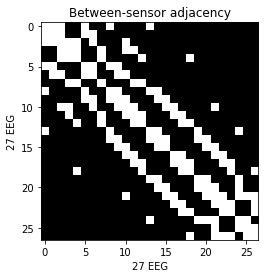

In [13]:
import matplotlib.pyplot as plt

word_evoked1.interpolate_bads(reset_bads=False)

# finding channel adjacency: informs us which channels are next to each other (for co-localisation)
adjacency, ch_names = mne.channels.find_ch_adjacency(word_evoked1.info, ch_type='eeg')

# plotting between-sensor adjacency
plt.imshow(adjacency.toarray(), cmap='gray',
           interpolation='nearest')
plt.xlabel('{} EEG'.format(len(ch_names)))
plt.ylabel('{} EEG'.format(len(ch_names)))
plt.title('Between-sensor adjacency')

In [14]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(X, n_permutations=1000, tail=0, threshold=100,
                                             n_jobs=-1, buffer_size=None, adjacency=adjacency, seed=4)

# selecting clusters with significant p-values
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

stat_fun(H1): min=14.925398 max=215.929530
Running initial clustering
Found 2 clusters
Permuting 999 times...


  0%|          |  : 0/999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


In [15]:
print(p_values)
print(good_cluster_inds)
print(clusters)

[0.001 0.001]
[0 1]
[(array([ 5,  6,  8,  9, 13, 14, 19, 24]),), (array([11, 12, 18, 26]),)]


The code for this plot is a bit long and complex but you don't have to go through it all, just swap in your conditions in the first couple of lines :-)

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# configuration of variables for visualisation
#colors = {"Word": "crimson", "Image": 'steelblue'}
colors = {"word1": "crimson", "word2": 'steelblue'}

# organising data for plotting
#evokeds = {cond: epochs[cond].average() for cond in ['Word', 'Image']} 
evokeds = {"word1": word_evoked1, "word2": word_evoked2}

# looping over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpacking cluster information
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # getting signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # creating spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialising the figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plotting average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(times=0, mask=mask, axes=ax_topo, cmap='Reds',
                          vmin=np.min, vmax=np.max, show=False,
                          colorbar=False, mask_params=dict(markersize=10))
    image = ax_topo.images[0]

    # creating additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # adding axes for colourbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        'Averaged F-map ({:0.3f} - {:0.3f} s)'.format(*sig_times[[0, -1]]))

    # adding new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    title = 'Cluster #{0}, {1} sensor'.format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    mne.viz.plot_compare_evokeds(evokeds, title=title, picks=ch_inds, axes=ax_signals,
                         colors=colors, show=False,
                         split_legend=True, truncate_yaxis='auto')

    # plotting temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)

    # clean-up
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=.05)
    plt.show()

ValueError: too many values to unpack (expected 2)